# Samples analysis
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/sample_analysis.ipynb)

Analyse cosmological model posterior samples.

In [ ]:
# Standard install
!pip -q install git+https://github.com/hsimonfroy/benchmark-field-level.git

# Editable install
# !pip -q install -e git+https://github.com/hsimonfroy/benchmark-field-level.git#egg=flbench
# import site; site.main() # for Colab only

import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from flbench.model import FieldLevelModel, default_config
from flbench.utils import pdump, pload
from getdist import plots

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

save_dir = "save_dir/"
save_path = save_dir+"example"
os.makedirs(save_dir, exist_ok=True)

## What are `Chains`?
### Chains object is a PyTree made of data, and optional metadata as groups and labels:
* `data` is a dict of arrays, of arbitrary dimensions.
* `groups` is a dict of list of strings, that serve as alias for fast querying and gathering.
* `labels` is a dict of strings used for plots.

### Chains has classical properties:
* `shape`, `ndim`, `dtype`, `size`...
* Chains can be merged with other Chains, dict, and UserDict using pipe `|`.

### Chains allows variety of keys for easy querying:
* **slicing and indexing**: `chains[3,1::2]` does exactly what you would expect
* **querying values**:

    ```python
    data = {'a':0,'b':1,'c':2}
    groups = {'ab':['a','b']}
    chains = Chains(data, groups)

    # Query by data key or groups
    assert chains['c','ab'] == (2, 0, 1) # 'ab' is an alias for 'a','b'

    # Special keys all '*', except '~', and all except '*~' 
    assert chains['*~ab'] == 2 # all except group 'ab'
    assert chains['*','~c'] == (0, 1) # all except 'c'

    # Keys are parsed in given order
    assert chains['~c','*'] == (0, 1, 2) # except 'c' (empty tuple) plus all
    ```
* **querying subchains** (as in `panda` but allows non-tabular data):
    ```python
    data = {'a':0,'b':1,'c':2}
    groups = {'ab':['a','b']}
    chains = Chains(data, groups)

    # Query by data key or groups
    ch0, ch1 = chains[['ab'],['c']] # split into subchains
    assert ch0.data == {'a': 0, 'b': 1}

    # Special keys all '*', except '~', and all except '*~' 
    ch0, ch1 = chains[['*~c'],['c']] # split into subchains
    assert ch1.data == {'c': 2}

    # Mix value and subchain querying
    ch0, v1 = chains[['ab'],'c']
    assert v1 == 2
    ```
### Chains can be transformed:
* chains can be `tree.map`ped
* chains can be stacked by groups, flatten, concatenated...
* chains transforms can themselves be applied on axes splits or cumulatively along axes.
* chains can be plotted, or cast to `getdist`.

## Example 1: assess MCMC convergence

In [ ]:
from flbench.mcbench import Chains
from flbench.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2
theme(usetex=True, font_size=12)

# Load chain files, which are just dictionaries of arrays, saved with jnp.savez
model = FieldLevelModel.load(save_dir+'model.yaml')

truth = dict(jnp.load(save_dir+'truth.npz'))
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

transforms = [
              lambda x:x[['*~diverging']],                          # load all variables except diverging boolean (in Numpyro output)
              partial(Chains.thin, thinning=1),                     # thin the chains
              model.reparam_chains,                                 # reparametrize sample variables into base variables
              partial(model.powtranscoh_chains, mesh0=mesh0),       # compute mesh statistics
              partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
              ]
chains = model.load_runs(save_path, 1, 3, transforms=transforms, batch_ndim=2)
names = ['cosmo','bias','init']
chains.shape

Loading: example, from run 1 to run 3 (included)
File save_dir/example_3.npz does not exist, stopping at run 2


{'Omega_m': (8, 64),
 'b1': (8, 64),
 'b2': (8, 64),
 'bn2': (8, 64),
 'bs2': (8, 64),
 'init_mesh': (8, 64, 10),
 'kptc': ((8, 64, 3), (8, 64, 3), (8, 64, 3), (8, 64, 3)),
 'logdensity': (8, 64),
 'mse_per_dim': (8, 64),
 'n_evals': (8, 64),
 'sigma8': (8, 64)}

### Inspecting chains
We look for mixed chains (no visible trends), `n_eff`>500, `r_hat`<1.01


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           b2     -0.04      0.02     -0.04     -0.07     -0.01    818.13      1.01
          bs2      0.06      0.09      0.05     -0.09      0.19    523.78      1.01
 init_mesh[0]      0.47      1.31      0.49     -1.66      2.54   3788.79      1.00
 init_mesh[1]      1.22      1.25      1.24     -0.74      3.35   3369.42      1.00
 init_mesh[2]      0.34      1.27      0.35     -1.63      2.53   3157.79      1.00
 init_mesh[3]     -0.04      1.38     -0.03     -2.30      2.23   2305.73      1.00
 init_mesh[4]     -1.40      1.32     -1.40     -3.59      0.71   2954.32      1.00
 init_mesh[5]     -1.42      1.39     -1.42     -3.68      0.89   2755.74      1.00
 init_mesh[6]     -0.21      1.34     -0.16     -2.32      1.99   2654.17      1.00
 init_mesh[7]     -1.85      1.46     -1.86     -4.20      0.60   2262.95      1.00
 init_mesh[8]     -0.98      1.49     -0.99     -3.31      1.53   2082.98  

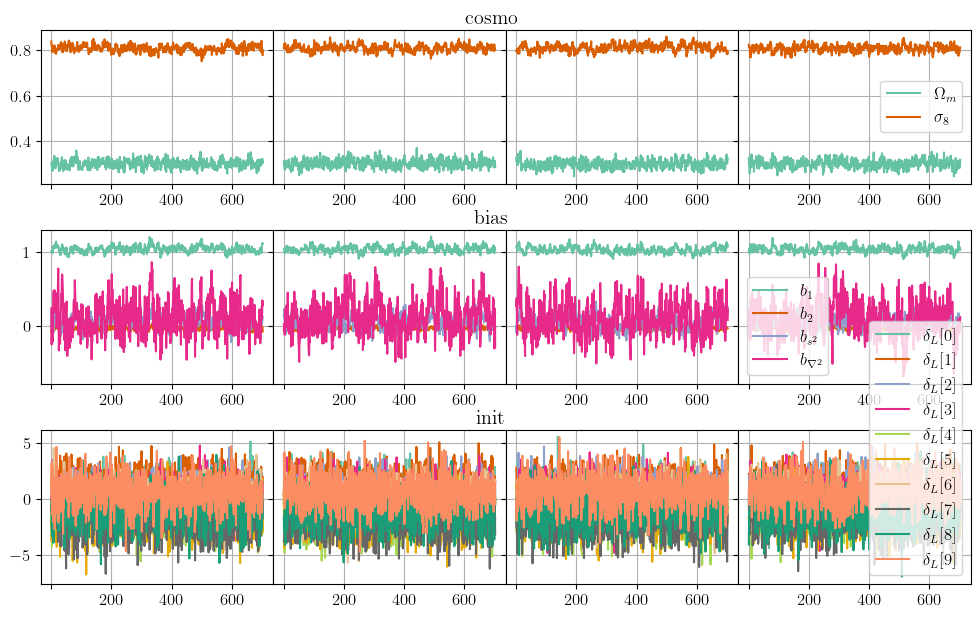

In [ ]:
plt.figure(figsize=(12,6))
chains[['*~kptc']].flatten().plot(names)
chains[['*~kptc']].print_summary()

Removed no burn in


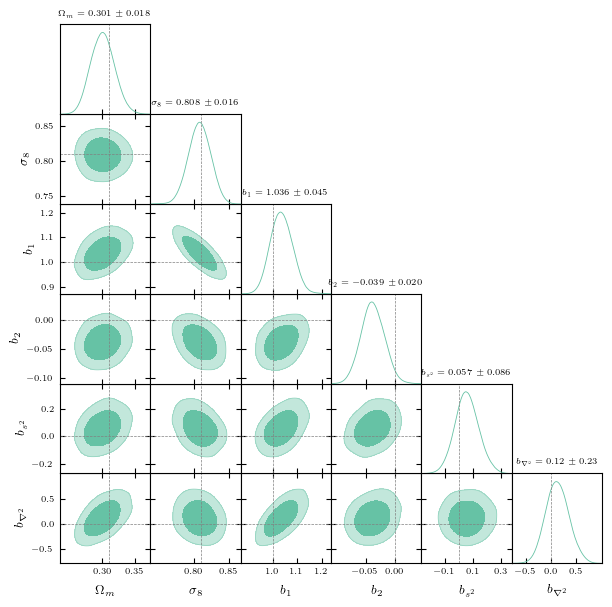

In [12]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)])

### Inspection at the field-Level
Power spectrum should converge close to the truth, and coherence must be on the order of the coherence between truth and obs

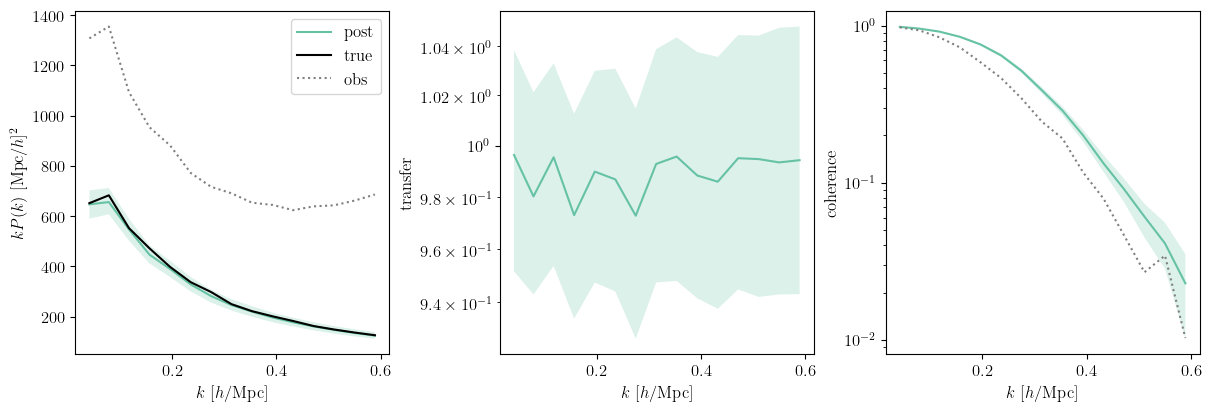

In [ ]:
prob = 0.95
log = False

plt.figure(figsize=(12, 4), layout="constrained")
kptc = tree.map(jnp.concatenate, chains['kptc'])
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptc), log=log, label='post')
plot_powtranscoh(*kptc, log=log, fill=prob)

plt.subplot(131)
plot_pow(*pow0, 'k', log=log, label='true')
plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
plt.legend()

plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')

## Example 2: quantify MCMC performance

### Number of eval per effective sample should converge. If so, that's a relevant metric.

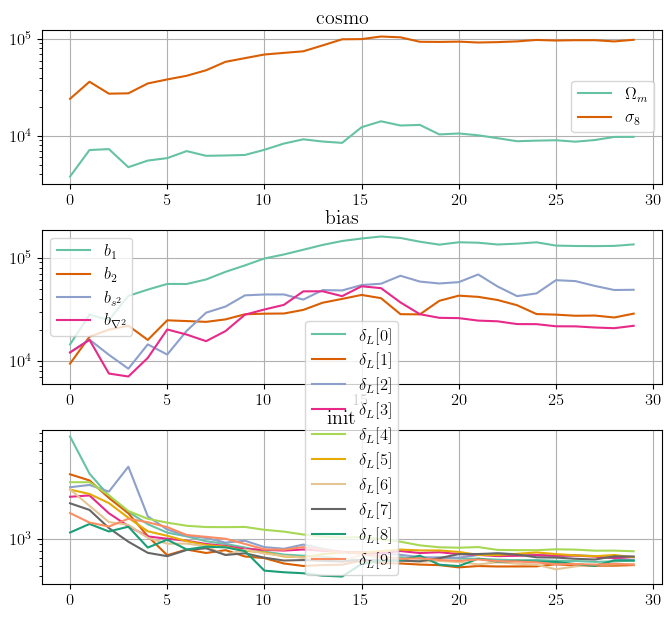

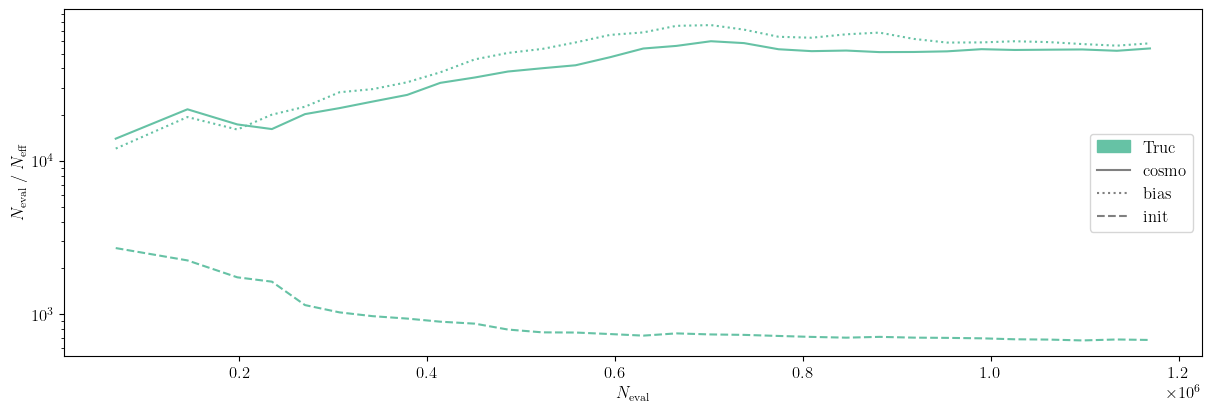

In [ ]:
plt.figure(figsize=(8, 6))
chains[['*~kptc']].flatten().cumtrans(Chains.eval_per_ess, 30).plot(names, 1, log=True)

labels = ['Truc']
metrics = []
cumess = chains[['*~kptc']].stackby(names).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn(metrics, labels):
    plt.figure(figsize=(12, 4), layout="constrained")
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
        for i_g, (st, g) in enumerate(zip(styles, names)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(names):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn(metrics, labels)
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");